In [1]:
import os
import math
import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim
from tensorflow.contrib.slim.python.slim import queues

/home/intern/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as mpcm

In [3]:
import sys
sys.path.append('../')

In [4]:
from datasets import dataset_factory
from nets import nets_factory
from preprocessing import preprocessing_factory
import tf_extended as tfe

In [5]:
isess = tf.InteractiveSession()

## Some drawing routines

In [6]:
def colors_subselect(colors, num_classes=9):
    dt = len(colors) // num_classes
    sub_colors = []
    for i in range(num_classes):
        color = colors[i*dt]
        if isinstance(color[0], float):
            sub_colors.append([int(c * 255) for c in color])
        else:
            sub_colors.append([c for c in color])
    return sub_colors

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """Draw a collection of lines on an image.
    """
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def draw_rectangle(img, p1, p2, color=[255, 0, 0], thickness=2):
    cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
    
    
def draw_bbox(img, bbox, shape, label, color=[255, 0, 0], thickness=2):
    p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
    p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
    cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
    p1 = (p1[0]+15, p1[1])
    cv2.putText(img, str(label), p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1)


def bboxes_draw_on_img(img, classes, scores, bboxes, colors, thickness=2):
    shape = img.shape
    for i in range(bboxes.shape[0]):
        bbox = bboxes[i]
        color = colors[classes[i]]
        # Draw bounding box...
        p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
        p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
        cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
        # Draw text...
        s = '%s/%.3f' % (classes[i], scores[i])
        p1 = (p1[0]-5, p1[1])
        cv2.putText(img, s, p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.4, color, 1)


In [7]:
colors = colors_subselect(mpcm.plasma.colors, num_classes=9)
colors_tableau = [(255, 255, 255), (31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150)]

## KITTI dataset

Check the KITTI pipeline and associated TFRecords files.

In [8]:
from datasets import kitti

DATASET_DIR = '/home/intern/data/KITTI/training/'
SPLIT_NAME = 'train'
BATCH_SIZE = 1

# Dataset provider loading data from the dataset.
dataset = kitti.get_split(SPLIT_NAME, DATASET_DIR)
provider = slim.dataset_data_provider.DatasetDataProvider(dataset, 
                                                          shuffle=True,
                                                          common_queue_capacity=2 * BATCH_SIZE,
                                                          common_queue_min=BATCH_SIZE)
[image, shape, bboxes, labels] = provider.get(['image', 'shape', 'object/bbox', 'object/label'])
print('Dataset:', dataset.data_sources, '|', dataset.num_samples)

Dataset: /home/intern/data/KITTI/training/kitti_train.tfrecord | 7481


In [9]:
# images = tf.train.batch(
#                 [image_crop],
#                 batch_size=BATCH_SIZE,
#                 num_threads=1,
#                 capacity=5 * BATCH_SIZE)

In [10]:
# Problem: image shape is not fully defined => random crop with deterministic size.
xy = tf.random_uniform((2, ), minval=0, maxval=shape[0] // 3, dtype=tf.int64)
image_crop = tf.slice(image, [0, 0, 0], [250, 250, 3])

print('Original vs crop:', image.get_shape(), image_crop.get_shape())

Original vs crop: (?, ?, 3) (250, 250, 3)


In [11]:
# with queues.QueueRunners(sess):
# Start populating queues.
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord)

In [12]:
# Draw groundtruth bounding boxes using TF routine.
image_bboxes = tf.squeeze(tf.image.draw_bounding_boxes(tf.expand_dims(tf.to_float(image) / 255., 0), 
                                                       tf.expand_dims(bboxes, 0)))

Image shape: (375, 1242, 3) [ 375 1242    3]
Bounding boxes: [[0.41706666 0.48261675 0.5046667  0.5070451 ]
 [0.48410666 0.31210145 0.54165334 0.34123188]
 [0.4372     0.5447665  0.51714665 0.5547343 ]
 [0.45256    0.40570852 0.5070133  0.4755314 ]
 [0.46656    0.41171497 0.49986666 0.4249678 ]
 [0.47026667 0.4286393  0.49405333 0.43694043]
 [0.46888    0.4505797  0.4884     0.46328503]]
Labels: [3 1 4 9 9 9 9]


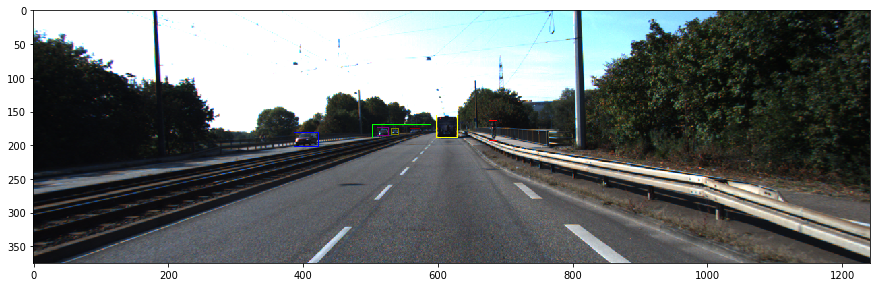

In [13]:
# Eval and display the image + bboxes.
rimg, rshape, rbboxes, rlabels = isess.run([image_bboxes, shape, bboxes, labels])

print('Image shape:', rimg.shape, rshape)
print('Bounding boxes:', rbboxes)
print('Labels:', rlabels)

fig = plt.figure(figsize = (15,15))
plt.imshow(rimg)

# SSD detector on KITTI

Try out the detector on KITTI images.

In [14]:
from nets import ssd_vgg_300
from nets import ssd_common

from preprocessing import ssd_vgg_preprocessing

ckpt_filename = '../History/ssd_300_kitti_20180219_numclass_removedontcare/model.ckpt-75000'
#ckpt_filename = '../logs/ssd_300_kitti_3/model.ckpt-48978'
#ckpt_filename = '../logs/ssd_300_kitti_4/model.ckpt-2573'
#ckpt_filename = '../logs/ssd_300_kitti_13/model.ckpt-149757'

In [15]:
# Image pre-processimg
out_shape = (300, 300) 
image_pre, labels_pre, bboxes_pre, bbox_img = \
    ssd_vgg_preprocessing.preprocess_for_eval(image, labels, bboxes, out_shape, 
                                              resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# SSD construction.
reuse = True if 'ssd' in locals() else None
params = ssd_vgg_300.SSDNet.default_params
params = params._replace(num_classes=9)
ssd = ssd_vgg_300.SSDNet(params)
with slim.arg_scope(ssd.arg_scope(weight_decay=0.0005)):
    predictions, localisations, logits, end_points = ssd.net(image_4d, is_training=False, reuse=reuse)

In [16]:
# Initialize variables.
init_op = tf.global_variables_initializer()
isess.run(init_op)
# Restore SSD model.
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

INFO:tensorflow:Restoring parameters from ../History/ssd_300_kitti_20180219_numclass_removedontcare/model.ckpt-75000


In [17]:
# Run model and get predictions.
[rimg, rpredictions, rlocalisations, glabels, gbboxes, rbbox_img] = \
    isess.run([image_4d, predictions, localisations, labels, bboxes_pre, bbox_img])
rimg = rimg[0]

# Update anchor boxes to image size.
ssd.update_feature_shapes(rpredictions)
anchors = ssd.anchors(rimg.shape, dtype=np.float32)

In [18]:
# Compute classes and bboxes from the net outputs.
rclasses, rscores, rbboxes,_,_ = ssd_common.tf_ssd_bboxes_select(rpredictions, rlocalisations,
                                                               select_threshold=0.8,
                                                               num_classes=9)
rbboxes = ssd_common.bboxes_clip(rbbox_img, rbboxes)
rclasses, rscores, rbboxes = ssd_common.bboxes_sort(rclasses, rscores, rbboxes, top_k=400, priority_inside=False)
rclasses, rscores, rbboxes = ssd_common.bboxes_nms(rclasses, rscores, rbboxes, threshold=0.3)

AttributeError: 'numpy.ndarray' object has no attribute 'get_shape'

Labels / scores: [(1, 0.99950624), (3, 0.98734331), (4, 0.95030951), (1, 0.95020562), (4, 0.94263786), (4, 0.93532395), (4, 0.91988581), (4, 0.9036305), (4, 0.90111971), (4, 0.90010756), (4, 0.88984841), (4, 0.88298821), (1, 0.87911272), (4, 0.86701053), (4, 0.86650562), (4, 0.85179883), (4, 0.84781027), (4, 0.83112371), (3, 0.82904977), (4, 0.81478012)]
Grountruth labels: [1, 5, 9]
[[ 0.47741333  0.38210949  0.56189334  0.41603866]
 [ 0.45034668  0.55679548  0.52936     0.56430757]
 [ 0.46672001  0.41279387  0.53072     0.42708534]]


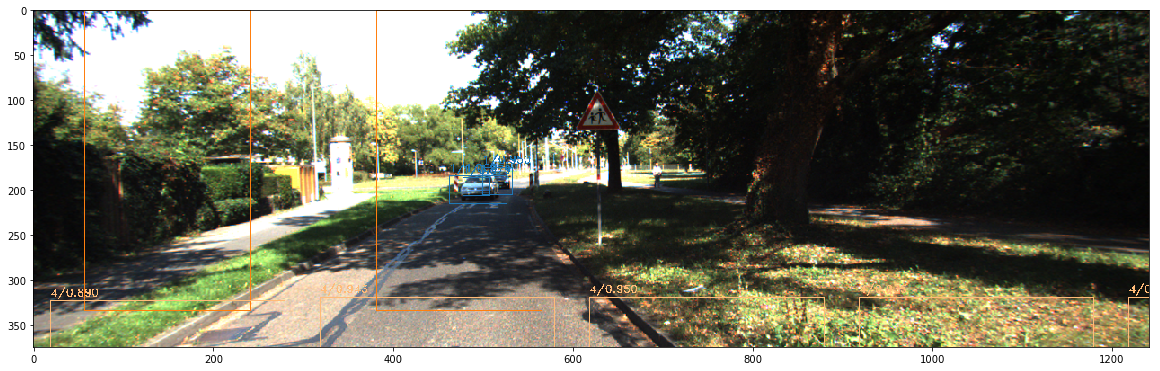

In [169]:
# Draw bboxes
img_bboxes = np.copy(ssd_vgg_preprocessing.np_image_unwhitened(rimg))
bboxes_draw_on_img(img_bboxes, rclasses, rscores, rbboxes, colors_tableau, thickness=1)
# bboxes_draw_on_img(img_bboxes, test_labels, test_scores, test_bboxes, colors_tableau, thickness=1)

print('Labels / scores:', list(zip(rclasses, rscores)))
print('Grountruth labels:', list(glabels))
print(gbboxes)

fig = plt.figure(figsize = (20,20))
plt.imshow(img_bboxes)

In [145]:
~isinstance(rpredictions[0], np.ndarray)

-2

In [21]:
PleaseStopHere;

NameError: name 'PleaseStopHere' is not defined

In [ ]:
def tanh_weighted(x, w=[1., 1.]):
    r = (w[0]*np.exp(x) - w[1]*np.exp(-x)) / (w[0]*np.exp(x) + w[1]*np.exp(-x))
    return r

x = np.arange(0, 1, 0.01)
y = (tanh_weighted((x - 0.5) * 8, [1, 1]) + 1) / 2.
plt.plot(x, y)

## Test SSD-300 model using TFRecords pipeline

Restore model and test it on some random images coming from Pascal TFRecords.

In [ ]:
from nets import ssd_vgg_300
from nets import ssd_common

from preprocessing import ssd_preprocessing

ckpt_filename = '/media/paul/DataExt4/PascalVOC/training/ckpts/SSD_300x300_ft/ssd_300_vgg.ckpt'
ckpt_filename = '/home/paul/Development/Research/SSD-Tensorflow/logs/ssd_300_vgg/model.ckpt-1084'

In [ ]:
# Image pre-processimg
out_shape = (300, 300) 
image_pre, labels_pre, bboxes_pre, bbox_img = \
    ssd_preprocessing.preprocess_for_eval(image, labels, bboxes, out_shape, 
                                          resize=ssd_preprocessing.Resize.PAD_AND_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# SSD construction.
reuse = True if 'ssd' in locals() else None
params = ssd_vgg_300.SSDNet.default_params
ssd = ssd_vgg_300.SSDNet(params)
with slim.arg_scope(ssd.arg_scope(weight_decay=0.0005)):
    predictions, localisations, logits, end_points = ssd.net(image_4d, is_training=False, reuse=reuse)
    
# SSD default anchor boxes.
img_shape = out_shape
layers_anchors = ssd.anchors(img_shape, dtype=np.float32)

In [ ]:
# Targets encoding.
target_labels, target_localizations, target_scores = ssd_common.tf_ssd_bboxes_encode(labels, bboxes_pre, layers_anchors)


In [ ]:
# Initialize variables.
init_op = tf.global_variables_initializer()
isess.run(init_op)
# Restore SSD model.
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

In [ ]:
# Run model.
[rimg, rpredictions, rlocalisations, glabels, gbboxes, rbbox_img, rt_labels, rt_localizations, rt_scores] = \
    isess.run([image_4d, predictions, localisations, labels, bboxes_pre, bbox_img, 
               target_labels, target_localizations, target_scores])

In [ ]:
# Compute classes and bboxes from the net outputs.
rclasses, rscores, rbboxes,_,_ = ssd_common.ssd_bboxes_select(rpredictions, rlocalisations, layers_anchors,
                                                               threshold=0.5, img_shape=img_shape, 
                                                               num_classes=9, decode=True)
rbboxes = ssd_common.bboxes_clip(rbbox_img, rbboxes)
rclasses, rscores, rbboxes = ssd_common.bboxes_sort(rclasses, rscores, rbboxes, top_k=400, priority_inside=False)
rclasses, rscores, rbboxes = ssd_common.bboxes_nms(rclasses, rscores, rbboxes, threshold=0.35)

In [ ]:
# Draw bboxes
img_bboxes = np.copy(ssd_preprocessing.np_image_unwhitened(rimg[0]))
bboxes_draw_on_img(img_bboxes, rclasses, rscores, rbboxes, colors_tableau, thickness=1)
# bboxes_draw_on_img(img_bboxes, test_labels, test_scores, test_bboxes, colors_tableau, thickness=1)

print('Labels / scores:', list(zip(rclasses, rscores)))
print('Grountruth labels:', list(glabels))
print(gbboxes)

fig = plt.figure(figsize = (10,10))
plt.imshow(img_bboxes)

In [ ]:
test_bboxes = []
test_labels = []
test_scores = []
for i in range(0, 3):
    yref, xref, href, wref = layers_anchors[i]
    ymin = yref - href / 2.
    xmin = xref - wref / 2.
    ymax = yref + href / 2.
    xmax = xref + wref / 2.
    bb = np.stack([ymin, xmin, ymax, xmax], axis=-1)
    
    idx = yref.shape[0] // 2
    idx = np.random.randint(yref.shape[0])
#     print(bb[idx, idx].shape)
    test_bboxes.append(bb[idx, idx])
    test_labels.append(np.ones(href.shape, dtype=np.int64) * i)
    test_scores.append(np.ones(href.shape))

test_bboxes = np.concatenate(test_bboxes)
test_labels = np.concatenate(test_labels)
test_scores = np.concatenate(test_scores)

print(test_bboxes.shape)
print(test_labels.shape)
print(test_scores.shape)


In [ ]:
rt_labels, rt_localizations, rt_scores
for i in range(len(rt_labels)):
    print(rt_labels[i].shape)
    idxes = np.where(rt_labels[i] > 0)
#     idxes = np.where(rt_scores[i] > 0.)
    print(idxes)
    print(rt_localizations[i][idxes])
    print(list(zip(rt_labels[i][idxes], rt_scores[i][idxes])))
    print()

In [ ]:
# fig = plt.figure(figsize = (8,8))
# plt.imshow(ssd_preprocessing.np_image_unwhitened(rimg[0]))
# print('Ground truth labels: ', rlabels)

In [ ]:
# Request threads to stop. Just to avoid error messages
# coord.request_stop()
# coord.join(threads)

In [ ]:
PleaseStopHere;

## Test SSD-300 model using sample images

Restore model and test it on some sample images.

In [ ]:
# Input placeholder.
net_shape = (300, 300)
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_preprocessing.preprocess_for_eval(
    img_input, labels, None, net_shape, resize=ssd_preprocessing.Resize.PAD_AND_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Re-define the model
reuse = True if 'ssd' in locals() else None
with slim.arg_scope(ssd.arg_scope(weight_decay=0.0005)):
    predictions, localisations, logits, end_points = ssd.net(image_4d, is_training=False, reuse=reuse)

In [ ]:
# Main processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=0.35, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    # Compute classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes, rlayers, ridxes = ssd_common.ssd_bboxes_select(
            rpredictions, rlocalisations, layers_anchors,
            threshold=select_threshold, img_shape=net_shape, num_classes=9, decode=True)
#     print(list(zip(classes, scores)))
#     print(rlayers)
#     print(ridxes)
    
    rbboxes = ssd_common.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = ssd_common.bboxes_sort(rclasses, rscores, rbboxes, 
                                                        top_k=400, priority_inside=True, margin=0.0)
    rclasses, rscores, rbboxes = ssd_common.bboxes_nms(rclasses, rscores, rbboxes, threshold=nms_threshold)
    # Resize bboxes to original image shape.
    rbboxes = ssd_common.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes
    

In [ ]:
# Test on demo images.
path = '../demo/'
image_names = sorted(os.listdir(path))
img = mpimg.imread(path + image_names[3])

rclasses, rscores, rbboxes =  process_image(img)

# Draw results.
img_bboxes = np.copy(img)
bboxes_draw_on_img(img_bboxes, rclasses, rscores, rbboxes, colors_tableau, thickness=2)

fig = plt.figure(figsize = (12, 12))
plt.imshow(img_bboxes)

In [ ]:
idxes = np.where(inside)
rscores[idxes]

## Some TensorFlow tests...

In [ ]:
a = tf.constant([[5.0, 2], [5.0, 2]])
b = tf.constant([5.0, 2])
c = a * b
d = tf.nn.l2_normalize(a, dim=1)
# We can just use 'c.eval()' without passing 'sess'
print(d.eval())

## A few tests on Caffe model files...

In [ ]:
import caffe
import numpy as np
from caffe.proto import caffe_pb2

caffe_filename = '/media/paul/DataExt4/PascalVOC/training/ckpts/SSD_300x300_ft/ssd_300_vgg.caffemodel'
caffemodel_params = caffe_pb2.NetParameter()
caffemodel_str = open(caffe_filename, 'rb').read()
caffemodel_params.ParseFromString(caffemodel_str)


In [ ]:
layers = caffemodel_params.layer
names = [(i, l.name) for i, l in enumerate(layers)]
types = set([l.type for i, l in enumerate(layers)])
print(types)
names

In [ ]:
layer = layers[59]
layer = layers[1]
print(layer.type)
a = np.array(layer.blobs[0].data)
s = layer.blobs[0].shape
print(s, 38*38)
# print(a)

In [ ]:
from nets import caffe_scope

In [ ]:
csc = caffe_scope.CaffeScope()

In [ ]:
d = {}
d[csc.conv_biases_init] = 0
d[csc.conv_biases_init] += 1

In [ ]:
min_dim = 300
mbox_source_layers = ['conv4_3', 'fc7', 'conv6_2', 'conv7_2', 'conv8_2', 'conv9_2']
min_ratio = 15
max_ratio = 90
step = int(math.floor((max_ratio - min_ratio) / (len(mbox_source_layers) - 2)))
min_sizes = []
max_sizes = []
for ratio in range(min_ratio, max_ratio + 1, step):
    min_sizes.append(min_dim * ratio / 100.)
    max_sizes.append(min_dim * (ratio + step) / 100.)
min_sizes = [min_dim * 7 / 100.] + min_sizes
max_sizes = [min_dim * 15 / 100.] + max_sizes

In [ ]:
print(min_sizes)
print(max_sizes)

In [ ]:
feat_shapes=[(38, 38), (19, 19), (10, 10), (5, 5), (3, 3), (1, 1)]

In [ ]:
steps = [8, 16, 32, 64, 100, 300]
offset = 0.5

In [ ]:
for i in range(len(steps)):
    print((feat_shapes[i][0] - offset) * steps[i] / 300, (feat_shapes[i][0] - offset) / feat_shapes[i][0])

In [ ]:
37.5 * 8. / 300

In [ ]:
.5 / 38

In [ ]:
~True